# Data Visualization Developer Workshop

In this data visualization workshop, we will be analyizing a realworld timeseries dataset to predict the future. This notebook demostrates how to download and prepare a live dataset, create data visualizations, and train and deploy a DeepAR model on the AWS SageMaker platform.

### Traffic Accident Prediction
In our hypothetical scenario, we are trying to predict the risk of traffic accidents in the City of Milwaukee. 

## Python Setup

Import the modules we will be using in our notebook

In [82]:
import datetime
import os
import sys
import time
import random
import json

from urllib.request import urlretrieve
import numpy as np
import pandas as pd

import boto3
import s3fs
import sagemaker
import matplotlib.pyplot as plt

In [66]:
%run -i helper.py

## Dataset Download and Preparation

We will first download our [datasource](https://data.milwaukee.gov/dataset/trafficaccident) from the [City of Milwaukee Data Portal](https://data.milwaukee.gov/).

In [69]:
url = "https://data.milwaukee.gov/dataset/5fafe01d-dc55-4a41-8760-8ae52f7855f1/resource/8fffaa3a-b500-4561-8898-78a424bdacee/download/trafficaccident.csv"
filename = "trafficaccident.csv"

In [70]:
if not os.path.isfile(filename):
    print("downloading dataset, can take a few minutes depending on your connection")
    urlretrieve(url, filename, reporthook=progress_report_hook)
else:
    print("File found skipping download")

File found skipping download


Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier.

In [124]:
csv_dataframe = pd.read_csv(filename, sep=",", parse_dates=True, error_bad_lines=False)
#csv_dataframe

In [126]:
ts_series = pd.to_datetime(csv_df['CASEDATE'], format='%Y-%m-%d %H:%M:%S.%f')
ts_series = ts_series.sort_values()
ts_series = ts_series.dropna()
ts_series = ts_series.rename("timestamp")
#ts_series

Since accidents are recorded individually in the orginal dataset, we need to aggrate the count of accidents into 1 hour bins. Also, for this particular dataeset, data prior to 2008 is incomplete. We will only keeps records starting at 1/1/2018.

In [128]:
df = pd.DataFrame(index=ts_series.rename("timestamp"))
df['count'] = 1
df = df.resample('1H').sum()
df = df['2008':]
#df

## Data Visualization


For the following visualizations, we want with full years, 2008 - 2018 in our case. We will create a dataframe for our target year.

In [159]:
df_2008_2018 = df['2008':'2018']
#df_2008_2018

### Graph Accidents Over Time

We will start with two simple line graphs. First graph will display the number of accidents over the entire set of data, allowing us to see trends spanning multiple years. Next the graph will overlay each year on one another, showing how years compare to one another as well as showing seasonality trends.

#### Steps

* First create a dataframe of the data we are going to plot. Since in the second graph we will be comparing years, we only want years with complete data. In this case it the years 2008 - 2018.

* Plot the dataframe. Resampling the dataframe will be necessary to show meaningful results. Expertiment with no resampling and by the hour, week, month, etc. 

* Next create a pivot table dataframe, with the month as the index and the yearas the columns. Aggregate using the sum function. 

* Plot the pivot dataframe.

* Use the plt.show() to output graph

#### Notes
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  

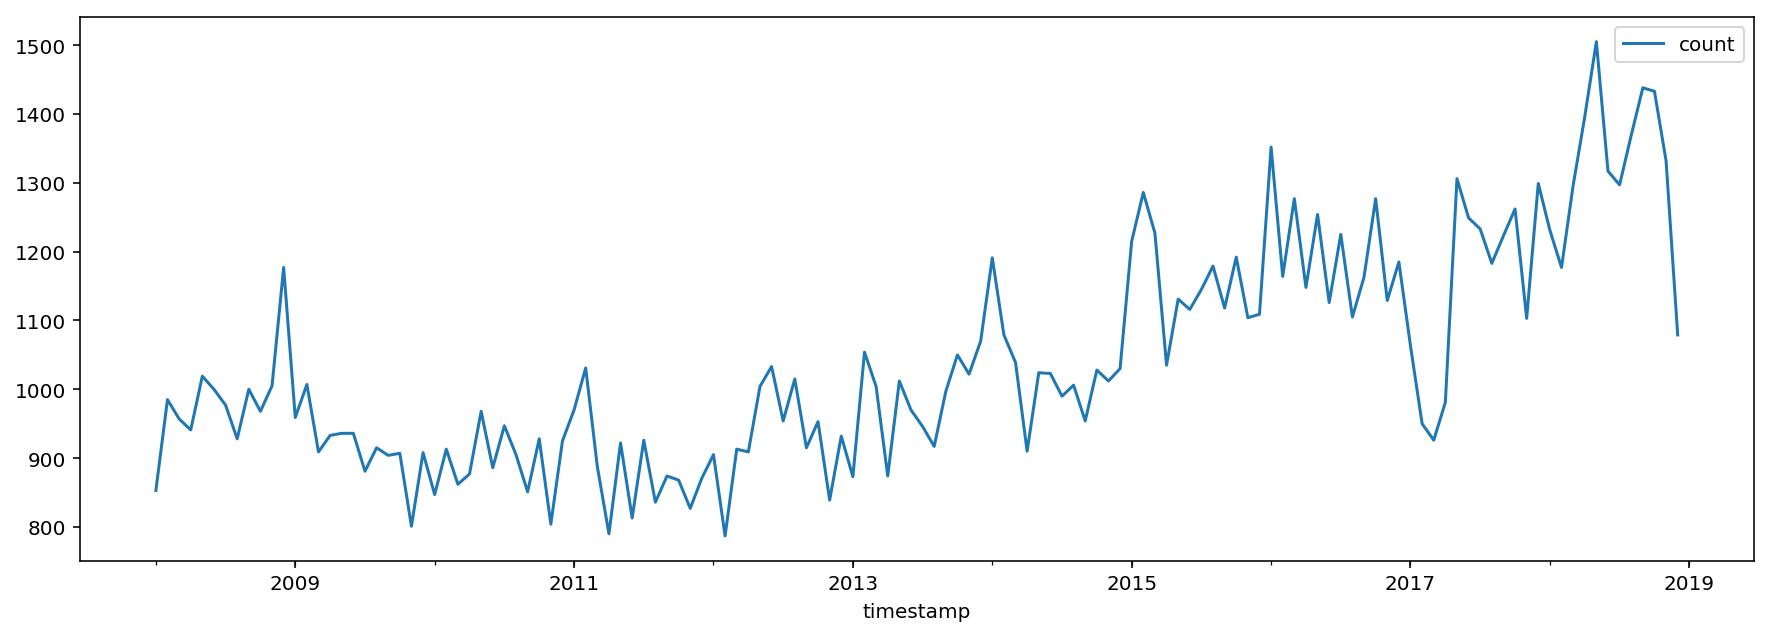

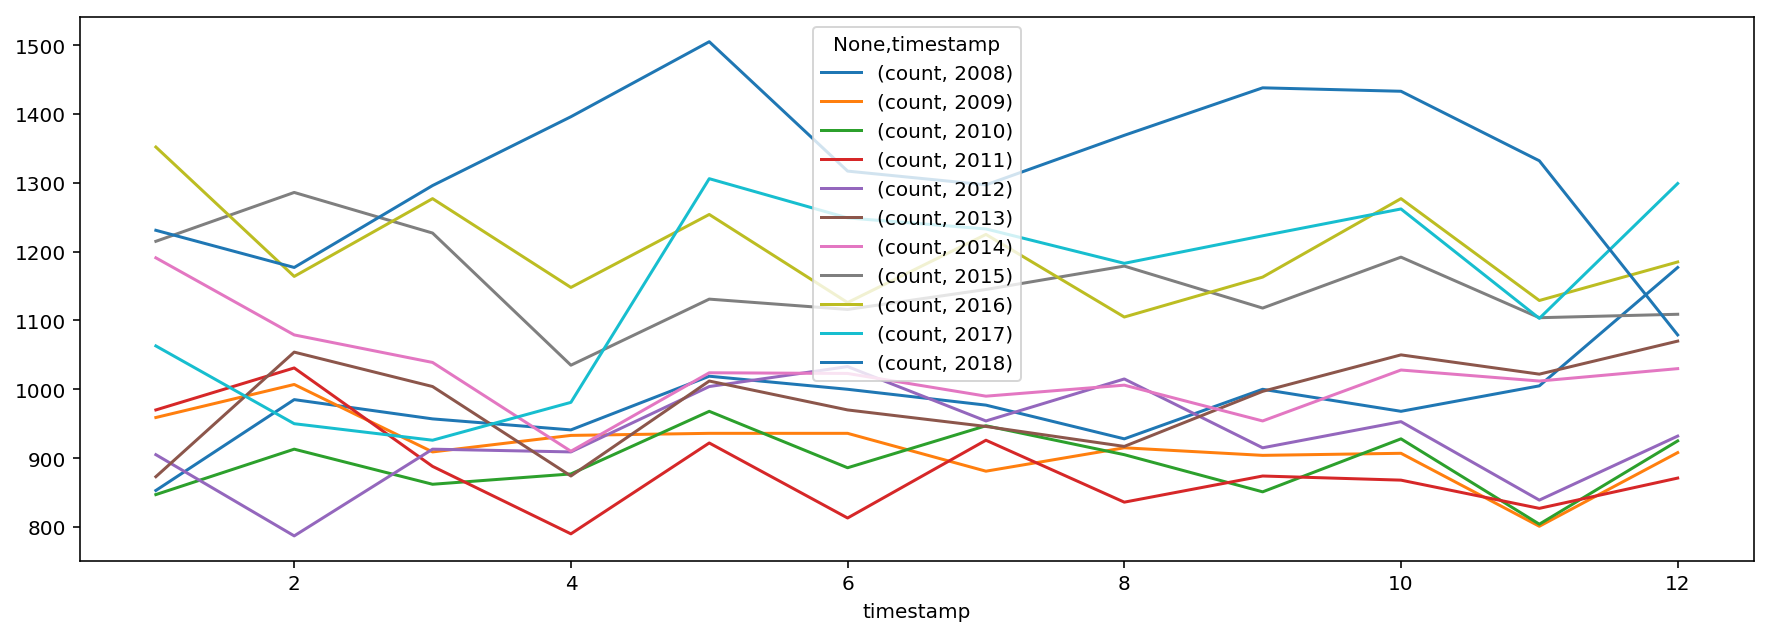

In [89]:
df_2008_2018.resample('1M').sum().plot()

pd.pivot_table(
    df_2008_2018,
    index = df_2008_2018.index.month,
    columns = df_2008_2018.index.year,
    aggfunc = 'sum'
).plot()

plt.show()

### Histograms  TODO
A histogram groups numbers into ranges, generally respresented as a bar chart. A histogram is a plot that lets you discover, and show, the underlying frequency distribution (shape) of a set of continuous data.  


#### Steps
* First create a dataframe of your sample data.
* Next create a pivot table dataframe, with the day of the week as the index (y axis) and hour of the day as the column (x axis). Aggregate using the mean function. 
* Plot the pivot dataframe using the imshow function. 

#### Notes
Monday = 0  
Midnight - 1:00AM = 0  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html  
https://matplotlib.org/tutorials/colors/colormaps.html 

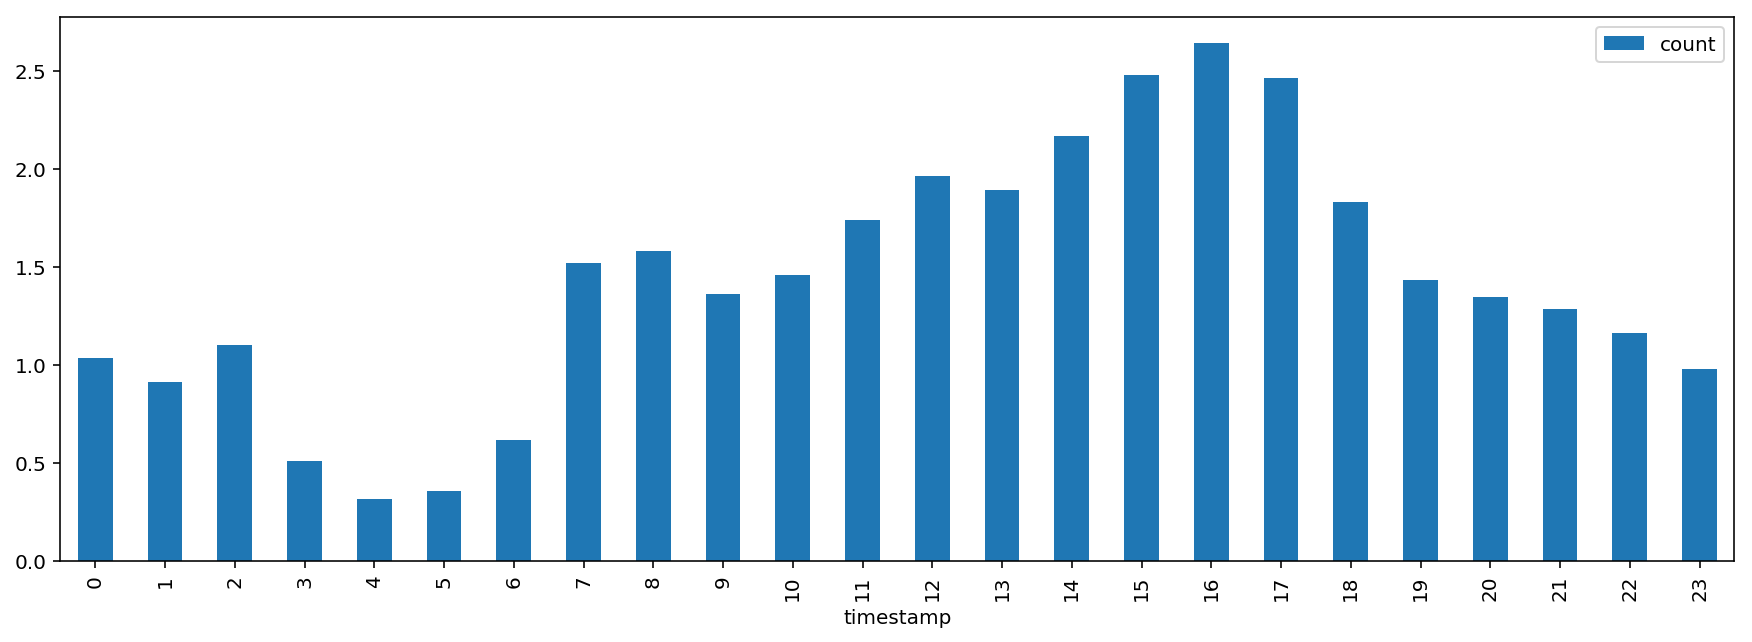

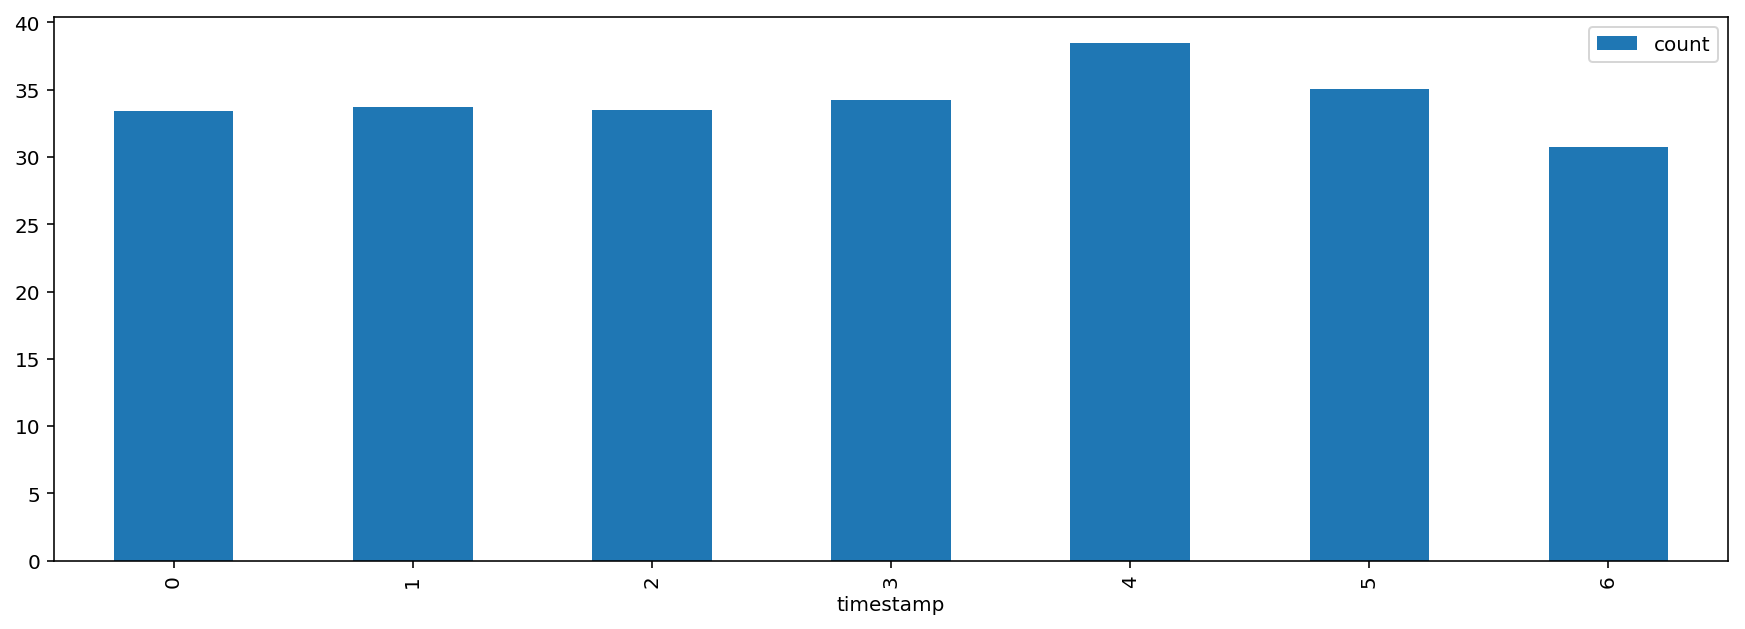

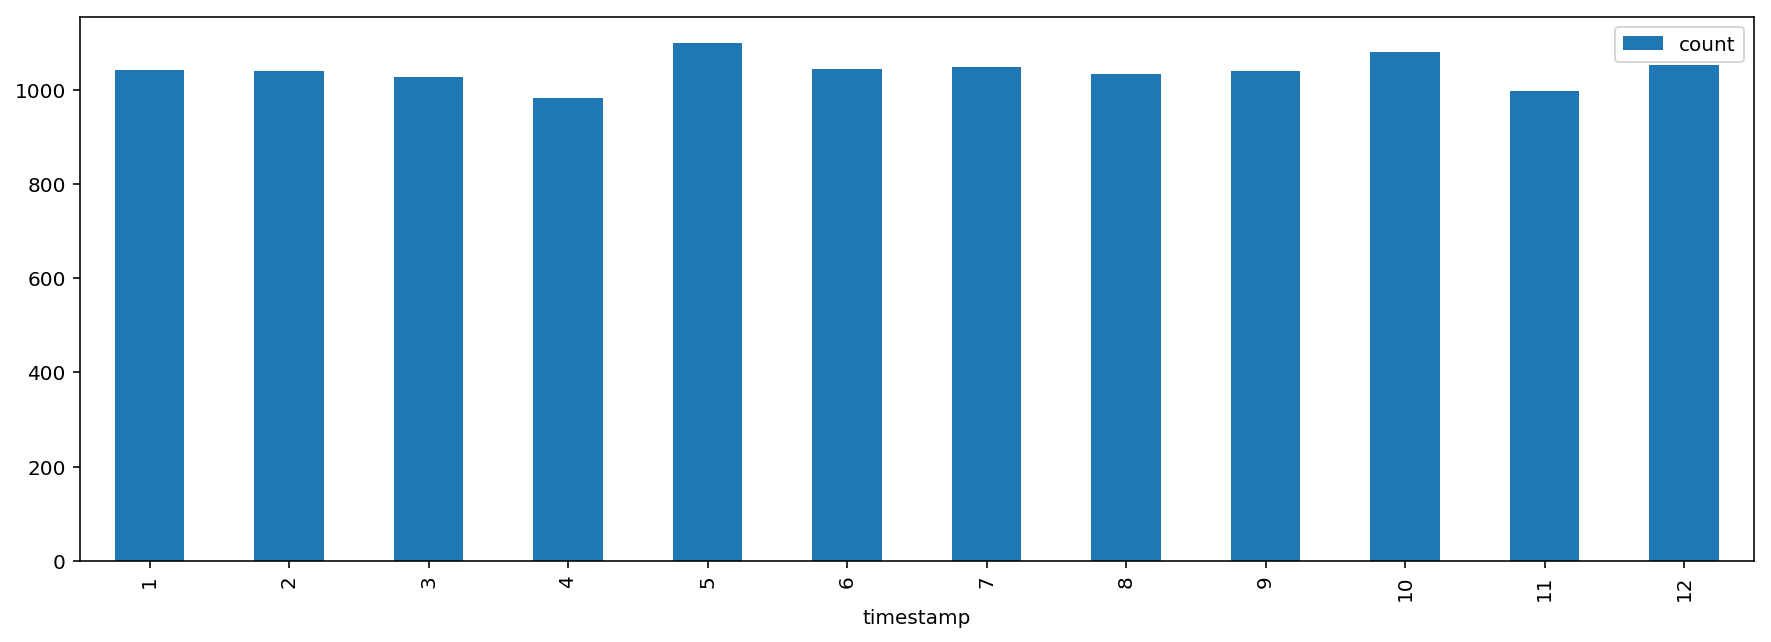

In [160]:
df_groupedbyhour = df_2008_2018.groupby(df_2008_2018.index.hour).mean();

df_day = df_2008_2018.resample('1D').sum()
df_groupedbyweekday = df_week.groupby(df_week.index.weekday).mean()

df_week = 
df_week.groupby(df_week.index.weekday).mean().plot(kind="bar")

df_month = df_2008_2018.resample('1M').sum()
df_month.groupby(df_month.index.month).mean().plot(kind="bar")

df_groupedbyhour.plot(kind="bar")



plt.show()

### Heatmap Graph
Let's create a heatmap, comparing the accidents that occur on each day of the week by hour. A heatmap displays the values of maxtrix in a two dimentions.

#### Steps
* First create a dataframe of your sample data.
* Next create a pivot table dataframe, with the day of the week as the index (y axis) and hour of the day as the column (x axis). Aggregate using the mean function. 
* Plot the pivot dataframe as a heatmap using the imshow function. 

#### Notes
Monday = 0  
Midnight - 1:00AM = 0  

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  
https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html  
https://matplotlib.org/tutorials/colors/colormaps.html  

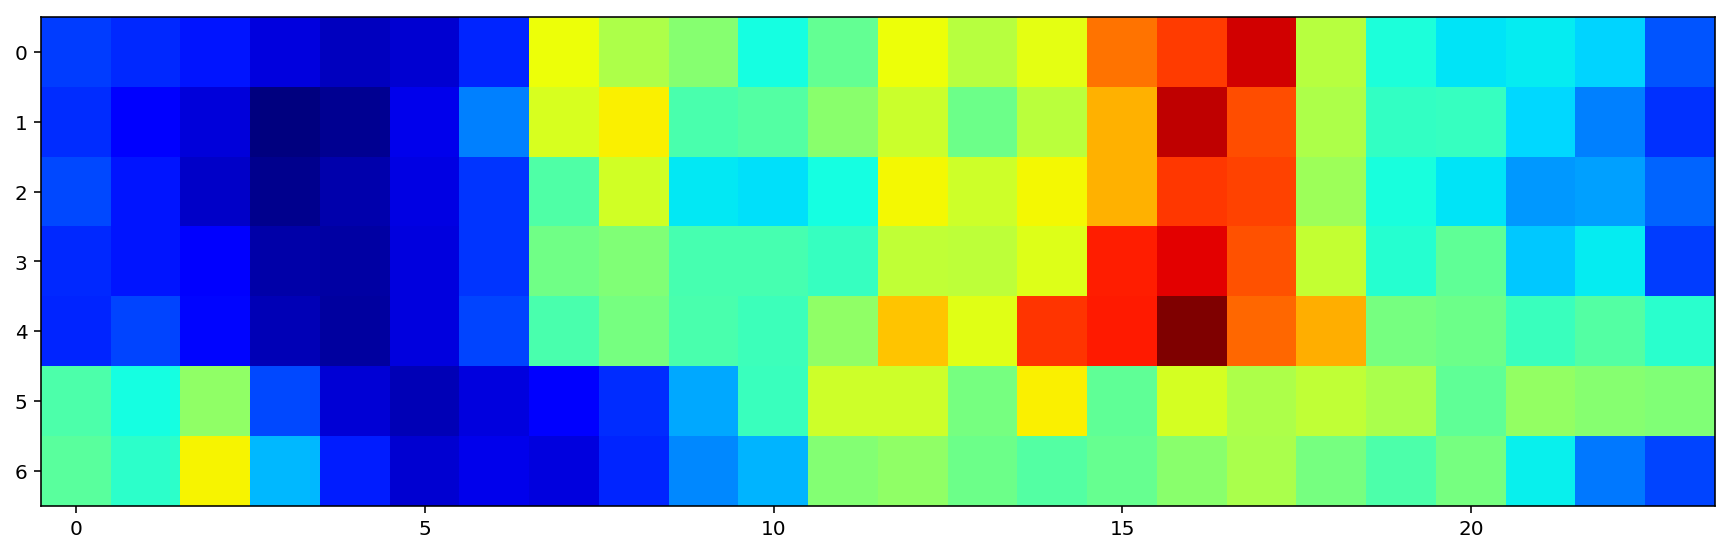

In [158]:
df_heatmap = df['2018-01-01':'2018-12-31']
pv_heatmap = pd.pivot_table(
    df_heatmap, 
    index = df_heatmap.index.weekday,
    columns = df_heatmap.index.hour,
    aggfunc='mean')

plt.figure(figsize=(15,5))
im = plt.imshow(pv_heatmap,cmap='jet')
plt.show()

## Machine Learning 

### SageMaker Setup

In [92]:
sagemaker_session = sagemaker.Session()

Before starting, we will configure the values to configure the S3 buckets.

The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. 

The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [98]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-traffic-accident-notebook'    # prefix used for all data stored within the bucket
s3_uid = 123123                                   # unique ID used for S3 data storage location

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-023630502738


In [103]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/uid_{}/{}/data".format(s3_bucket, s3_uid, s3_prefix)
s3_output_path = "s3://{}/uid_{}/{}/output".format(s3_bucket, s3_uid, s3_prefix)

### Setup Test Data

To configure DeepAR, we need to split the data into training and testing data. For the training data, we will use data from 2008 through 2017, split by year. The training data will be all of 2018.

In [106]:
time_series_training = []
time_series_training.append(df["2008":"2008"]['count'])
time_series_training.append(df["2009":"2009"]['count'])
time_series_training.append(df["2010":"2010"]['count'])
time_series_training.append(df["2011":"2011"]['count'])
time_series_training.append(df["2012":"2012"]['count'])
time_series_training.append(df["2013":"2013"]['count'])
time_series_training.append(df["2014":"2014"]['count'])
time_series_training.append(df["2015":"2015"]['count'])
time_series_training.append(df["2016":"2016"]['count'])
time_series_training.append(df["2017":"2017"]['count'])

time_series = []
time_series.append(df['2018':'2018']['count'])

### Write training and test data to S3

Now that we have the data arrays prepared, let us copy them to S3 where DeepAR can access them. This may take a couple of minutes, depending on your connection.

In [107]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### Configure DeepAR estimator training job

We can now define the estimator that will launch the training job and configure the container image to be used for the region that we are running in.
#### Notes
https://sagemaker.readthedocs.io/en/stable/estimators.html#sagemaker.estimator.Estimator

In [109]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path=s3_output_path
)

### Set Hyperparameters

Hyperparameters are parameters used for to configure machine learning algorthim, set are outside prior to the training process. Changing these parameters can have a dramatic impact on the accurary and performance of the model. That said, tuning most of these hyperparameters is outside the scope of this workshop. The relevant hyperparameters are as follows:

 * **time_freq** - The target frequency interval of the data. Hourly in this example.
 * **context_length** - How far in the past DeepAR's network can see. Higher values may result in more accuracy at the expense of training time and expense, and computing resources to execute model.
 * **prediction_length** - How far in the future DeepAR's network can predict. Like **context_length**, higher values are more taxing during model training and execution. 

#### Notes
https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html  

In [110]:
time_freq = 'H'
prediction_length = 336 # 2 weeks (24 * 14)
context_length = 336

In [111]:
hyperparameters = {
    "time_freq": time_freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "55",
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "40",
    "mini_batch_size": "33",
    "learning_rate": "0.00256",
    "dropout_rate": "0.045",
    "early_stopping_patience": "10"
}
estimator.set_hyperparameters(**hyperparameters)

### Run DeepAR estimator job

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last prediction_length points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [112]:
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-04-25-03-06-49-318


2019-04-25 03:06:49 Starting - Starting the training job...
2019-04-25 03:06:50 Starting - Launching requested ML instances......
2019-04-25 03:07:59 Starting - Preparing the instances for training...
2019-04-25 03:08:45 Downloading - Downloading input data
2019-04-25 03:08:45 Training - Downloading the training image.....
Arguments: train
[04/25/2019 03:09:32 INFO 140460608726848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[04/25/2019 03:09:32 

[04/25/2019 03:10:41 INFO 140460608726848] Epoch[2] Batch[10] avg_epoch_loss=1.682577
[04/25/2019 03:10:41 INFO 140460608726848] #quality_metric: host=algo-1, epoch=2, batch=10 train loss <loss>=1.672734879
[04/25/2019 03:10:41 INFO 140460608726848] Epoch[2] Batch [10]#011Speed: 44.43 samples/sec#011loss=1.672735
[04/25/2019 03:10:41 INFO 140460608726848] processed a total of 355 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 8484.555006027222, "sum": 8484.555006027222, "min": 8484.555006027222}}, "EndTime": 1556161841.250221, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556161832.765598}

[04/25/2019 03:10:41 INFO 140460608726848] #throughput_metric: host=algo-1, train throughput=41.8401709307 records/second
[04/25/2019 03:10:41 INFO 140460608726848] #progress_metric: host=algo-1, completed 7 % of epochs
[04/25/2019 03:10:41 INFO 140460608726848] #quality_metric: host=algo-1, epoch=2, train loss <loss>=1.6825770

[04/25/2019 03:11:22 INFO 140460608726848] processed a total of 330 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 7717.910051345825, "sum": 7717.910051345825, "min": 7717.910051345825}}, "EndTime": 1556161882.207736, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556161874.48976}

[04/25/2019 03:11:22 INFO 140460608726848] #throughput_metric: host=algo-1, train throughput=42.7570751093 records/second
[04/25/2019 03:11:22 INFO 140460608726848] #progress_metric: host=algo-1, completed 20 % of epochs
[04/25/2019 03:11:22 INFO 140460608726848] #quality_metric: host=algo-1, epoch=7, train loss <loss>=1.5928218726
[04/25/2019 03:11:22 INFO 140460608726848] loss did not improve
[04/25/2019 03:11:23 INFO 140460608726848] Epoch[8] Batch[0] avg_epoch_loss=1.618296
[04/25/2019 03:11:23 INFO 140460608726848] #quality_metric: host=algo-1, epoch=8, batch=0 train loss <loss>=1.61829607414
[04/25/2019 03:11:26 INFO 14046060872684

[04/25/2019 03:12:09 INFO 140460608726848] Epoch[13] Batch[5] avg_epoch_loss=1.572250
[04/25/2019 03:12:09 INFO 140460608726848] #quality_metric: host=algo-1, epoch=13, batch=5 train loss <loss>=1.57224994236
[04/25/2019 03:12:09 INFO 140460608726848] Epoch[13] Batch [5]#011Speed: 43.67 samples/sec#011loss=1.572250
[04/25/2019 03:12:13 INFO 140460608726848] Epoch[13] Batch[10] avg_epoch_loss=1.568513
[04/25/2019 03:12:13 INFO 140460608726848] #quality_metric: host=algo-1, epoch=13, batch=10 train loss <loss>=1.56402856075
[04/25/2019 03:12:13 INFO 140460608726848] Epoch[13] Batch [10]#011Speed: 44.42 samples/sec#011loss=1.564029
[04/25/2019 03:12:13 INFO 140460608726848] processed a total of 346 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 8511.315107345581, "sum": 8511.315107345581, "min": 8511.315107345581}}, "EndTime": 1556161933.054149, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556161924.542411}

[04/25/

#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 13480.004072189331, "sum": 13480.004072189331, "min": 13480.004072189331}}, "EndTime": 1556162053.131324, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1556162039.651413}

[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, RMSE): 1.38557077091
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, mean_wQuantileLoss): 0.503546
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, wQuantileLoss[0.1]): 0.222106
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, wQuantileLoss[0.2]): 0.382161
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, wQuantileLoss[0.3]): 0.502917
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, wQuantileLoss[0.4]): 0.607597
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, wQuantileLoss[0.5]): 0.659659
[04/25/2019 03:14:13 INFO 140460608726848] #test_score (algo-1, 

### Start Trained DeepAR Model Endpoint
Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note:** remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [ ]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-04-25-03-06-49-318
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-04-25-03-06-49-318
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-04-25-03-06-49-318


-------------

Create an instance of the DeepARPredictor utility class. This will be used to help be used to make a request to the endpoint

In [115]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(time_freq, prediction_length)

In [120]:
time_series_predict = [time_series_training[9]]

Now we can use the previously created predictor object to generate the predicted data.

In [121]:
list_of_prediction_dataframes = predictor.predict(time_series_predict, quantiles=["0.1", "0.5", "0.9"])

In [118]:
list_of_prediction_dataframes

[                          0.1       0.5       0.9
 2018-01-01 00:00:00 -0.594669  1.322195  3.086957
 2018-01-01 01:00:00 -0.162615  1.499874  2.912183
 2018-01-01 02:00:00 -0.679667  0.940276  2.718731
 2018-01-01 03:00:00 -0.879540  0.584260  2.066708
 2018-01-01 04:00:00 -0.607585  0.346988  1.469023
 2018-01-01 05:00:00 -0.572678  0.282187  1.368729
 2018-01-01 06:00:00 -0.082765  1.247747  2.715142
 2018-01-01 07:00:00  0.163846  1.947724  3.691254
 2018-01-01 08:00:00  0.367862  2.813478  4.988540
 2018-01-01 09:00:00  0.247563  2.657107  5.203444
 2018-01-01 10:00:00  0.118043  2.338734  5.442197
 2018-01-01 11:00:00 -0.199952  2.661324  5.619218
 2018-01-01 12:00:00 -0.207258  2.879421  4.872356
 2018-01-01 13:00:00  0.746601  3.018492  5.950572
 2018-01-01 14:00:00 -0.895089  2.617810  6.427844
 2018-01-01 15:00:00  0.285957  2.738980  6.355088
 2018-01-01 16:00:00 -0.080858  3.002252  5.226262
 2018-01-01 17:00:00  0.407369  2.994689  5.694880
 2018-01-01 18:00:00  0.248765 

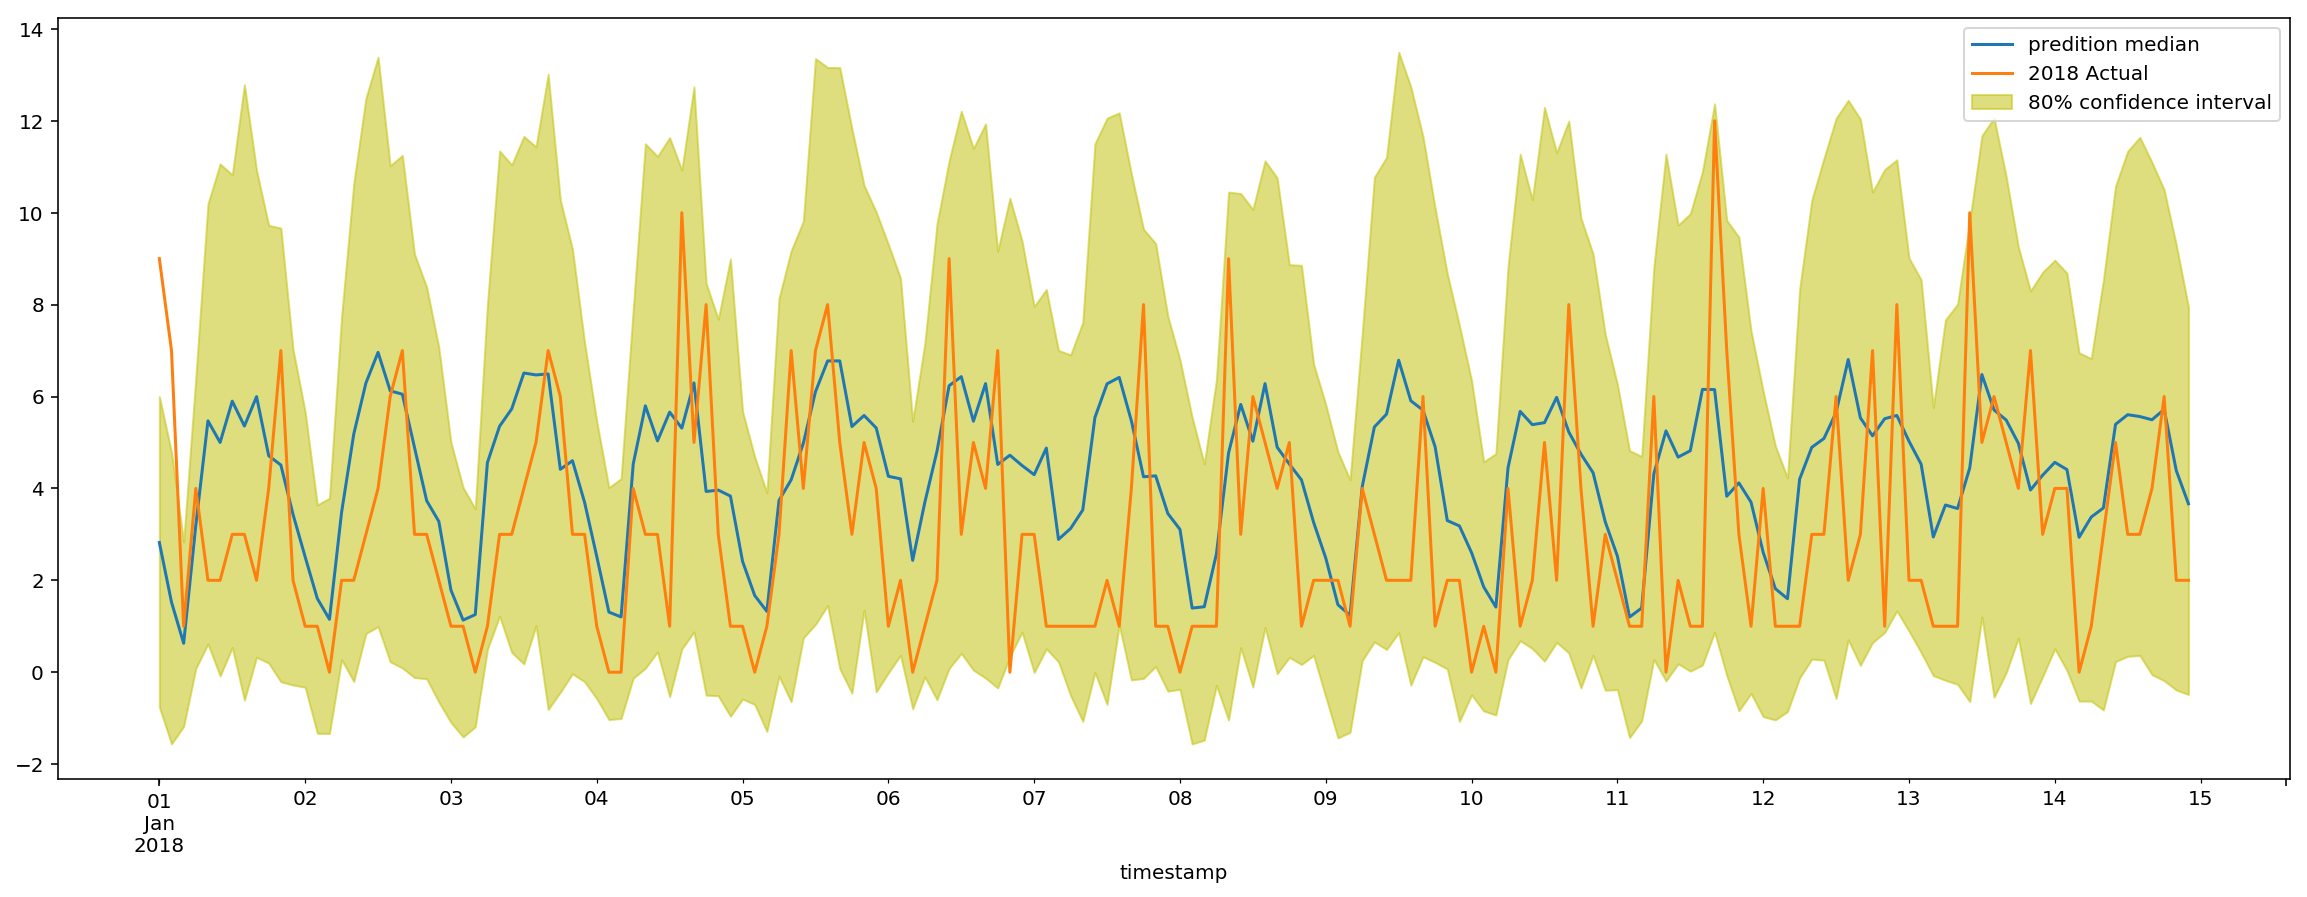

In [119]:
#parameters for time resolution and range to play
plot_interval = '2h'
plot_slice = slice('2018-01-01','2018-01-14')

#Create dataframes and series to plot
toplot_dataframe = list_of_prediction_dataframes[0][plot_slice].resample(plot_interval).sum()
toplotmedian = toplot_dataframe['0.5']
toplot10 = toplot_dataframe['0.1']
toplot90 = toplot_dataframe['0.9']

plt.figure(figsize=(20,7))

#Plot median line and 80% confidence interval area
toplotmedian.plot(label='predition median')
plt.fill_between(toplot10.index, toplot10, toplot90, color='y', alpha=.5, label='80% confidence interval')

#Create and plot actual data series
actual_data_series = time_series[0][plot_slice].resample(plot_interval).sum()
actual_data_series.plot(label='2018 Actual')


plt.legend()
plt.show()

### Delete endpoint

In [25]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DEMO-deepar-2019-04-24-20-59-58-922
